In [1]:
import numpy as np # scientific computing
import pandas as pd # data loading and processing
import os # os operations
import matplotlib.pyplot as plt # for generating figures
import math
import matplotlib.dates as mdates
import seaborn as sns # for generating visualizations, better support with pandas than matplotlib

# Colorectal data analysis

In [18]:
# load colorectal data
df = pd.read_csv("TCGA.COADREAD.sampleMap_HiSeqV2", index_col=0, sep = "\t")
df

,TCGA-CA-5256-01,TCGA-AZ-6599-01,TCGA-AA-3655-01,TCGA-A6-6137-01,TCGA-CK-4952-01,TCGA-A6-5657-01,TCGA-AD-6963-01,TCGA-AA-3663-11,TCGA-A6-6138-01,TCGA-A6-A567-01,...,TCGA-CI-6620-01,TCGA-AG-3725-01,TCGA-AH-6643-01,TCGA-DY-A0XA-01,TCGA-AF-3400-11,TCGA-EI-6506-01,TCGA-AF-2692-11,TCGA-AF-A56K-01,TCGA-DC-6154-01,TCGA-AG-3592-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.1616,11.1212,11.0245,11.0576,10.5660,10.4189,10.8635,11.0543,10.3716,11.5113,...,10.9090,11.2637,10.3559,10.4947,11.4043,11.3188,10.7338,10.7196,11.3442,10.7753
HIF3A,3.7172,2.3437,2.0858,6.0759,1.9506,5.4777,4.4634,8.4492,1.8943,4.7474,...,3.3234,1.4272,2.3162,3.1015,5.7645,3.0008,7.7070,6.7224,6.1021,5.0876
RNF17,0.0000,0.0000,0.5495,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
RNF10,10.4857,11.6878,11.5062,11.7053,11.8684,11.4861,11.4397,11.9238,11.7580,11.4303,...,11.3939,12.0311,11.6253,11.3194,12.1388,11.5119,11.8789,11.1103,11.5538,11.3385
RNF11,10.5157,10.3830,9.9334,10.2443,9.8537,10.1777,9.3104,11.0780,10.4115,10.6953,...,9.6838,10.3410,10.1512,9.8840,10.4810,9.9720,11.2593,9.6058,9.7442,9.2784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTRF,9.4792,8.9279,10.6716,10.5038,10.4412,12.5156,10.2790,13.3075,11.5264,11.1985,...,12.6033,9.4449,11.3169,10.3013,10.7764,10.7430,13.7595,12.2902,11.3946,10.8611
BCL6B,5.7645,4.8842,7.0262,6.9352,6.7306,7.7286,6.3278,7.0410,7.2633,6.8165,...,8.1765,5.8791,7.5720,6.6007,5.7905,7.3037,8.2791,8.6242,7.8983,7.0589
GSTK1,12.5517,11.6017,12.4103,11.2349,10.5621,11.3806,11.8569,11.8092,12.0823,12.3234,...,11.5012,12.6351,11.5202,11.3869,12.0445,11.0788,11.3977,11.2602,11.8158,12.1677


In [19]:
# get names of nrf2 target genes
nrf2_names = pd.read_csv("nrf2 target genes.csv", index_col=None, header= None).T
nrf2_names = nrf2_names.loc[0].to_list()

# get relevant genes (RRM2B and NRF2 target genes)
data = df.loc[nrf2_names + ["RRM2B", "G6PD"]]

# # get only patients with cancer samples
# nrf2 = nrf2[patients]

data.head() # genes x patients


,TCGA-CA-5256-01,TCGA-AZ-6599-01,TCGA-AA-3655-01,TCGA-A6-6137-01,TCGA-CK-4952-01,TCGA-A6-5657-01,TCGA-AD-6963-01,TCGA-AA-3663-11,TCGA-A6-6138-01,TCGA-A6-A567-01,...,TCGA-CI-6620-01,TCGA-AG-3725-01,TCGA-AH-6643-01,TCGA-DY-A0XA-01,TCGA-AF-3400-11,TCGA-EI-6506-01,TCGA-AF-2692-11,TCGA-AF-A56K-01,TCGA-DC-6154-01,TCGA-AG-3592-01
sample,,,,,,,,,,,,,,,,,,,,,
ABCC5,9.1003,8.0741,8.6726,10.3389,7.9340,8.8935,8.7863,9.4007,8.9542,9.7352,...,9.5538,9.4273,8.7934,9.9251,8.9677,9.2458,9.3885,10.3452,9.4014,9.4356
ADD3,12.4250,11.1759,12.0983,11.8299,11.6108,11.2129,11.2289,11.6179,11.3121,12.4282,...,11.8949,12.1307,11.6005,12.4329,11.7970,11.5516,11.6201,11.3381,11.5697,11.7986
APIP,10.3187,10.0445,10.3716,10.4251,8.4199,8.3672,8.8939,8.8942,8.0130,9.0011,...,9.2119,9.8890,9.3167,9.1937,8.7473,9.4180,8.5389,9.2647,9.2049,9.6461
ASF1A,9.9020,9.0536,7.8514,8.7826,7.8443,8.7147,8.8000,8.5831,8.2284,8.2870,...,8.8556,8.8283,9.2547,9.1669,8.9057,8.2334,8.3755,8.5076,9.1205,8.8599
AXIN2,13.0304,11.8099,11.4597,13.5735,10.4219,11.8821,11.5411,9.7009,10.7300,13.5576,...,12.1364,13.1060,13.3494,13.2426,10.1581,12.2493,8.8798,12.3826,11.5409,11.6175


In [20]:
# scale data
data = data/math.log2(10)

data = data.T

# for each sequenced gene were rescaled to set the median equal to 1
data=(data-data.median()+1)/data.std()

# for each patient, average across all normalised expression values
rrm2b = data[["RRM2B", "G6PD"]] # genes x patients
data.drop(["RRM2B", "G6PD"], inplace=True, axis = 1)
data["NFE2L2 activity"] = data.mean(axis = 1)
data = pd.concat([data, rrm2b], axis = 1) # patients x genes + NFE2L2 activity
data.head()

sample,ABCC5,ADD3,APIP,ASF1A,AXIN2,BMP4,CAP2,CAT,CCDC104,CCDC53,...,PTGR1,SH3RF2,SRP9,SUB1,TBC1D14,TSEN2,TXNRD1,NFE2L2 activity,RRM2B,G6PD
TCGA-CA-5256-01,4.827383,7.175595,5.832811,9.985577,3.094014,1.923664,0.249436,6.939619,8.779609,7.637821,...,3.918049,4.892015,11.438271,10.482767,5.948322,4.856786,7.239972,5.471040,7.085939,5.172992
TCGA-AZ-6599-01,3.263900,4.931092,5.495193,8.129984,2.291340,2.019730,-0.095860,4.994999,5.588509,5.983385,...,3.203854,4.882376,8.448499,5.743993,7.945114,4.676630,6.061869,4.685337,5.113370,4.745580
TCGA-AA-3655-01,4.175754,6.588549,5.897946,5.500570,2.061027,3.516308,1.662980,5.950742,6.170399,6.071651,...,4.775576,5.536869,8.969887,5.947795,8.553976,3.954347,7.638577,5.184259,5.231906,7.375236
TCGA-A6-6137-01,6.714471,6.106262,5.963820,7.537261,3.451189,1.836762,1.584905,6.450755,5.140522,5.098921,...,5.217208,5.552463,7.537262,5.699324,9.401077,6.336610,8.001276,5.067906,6.337349,6.655535
TCGA-CK-4952-01,3.050449,5.712562,3.494849,5.485042,1.378507,2.748088,1.478709,4.192842,6.056600,5.295710,...,3.386202,3.769864,9.024756,6.939102,7.965500,4.767192,9.365945,4.617709,5.554764,5.015444


In [21]:
y, x = data["NFE2L2 activity"].to_numpy(), data["RRM2B"].to_numpy()

#find line of best fit
a, b = np.polyfit(x, y, 1)

In [22]:
iqr = data["G6PD"].T.describe()


In [32]:
# bin the patients into quartiles based on G6PD expression

data["G6PD levels"] = pd.cut(data["G6PD"],
                bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                labels=["Bottom 25%", "-", "Top 25%"])


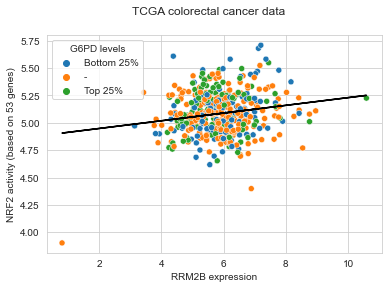

In [33]:
fig, axs = plt.subplots(1, 1, sharey=True)
sns.set_style("whitegrid")
sns.scatterplot(data=data, x="RRM2B", y="NFE2L2 activity", hue = "G6PD levels", color="green", ax=axs)
plt.plot(x, a*x+b, color="black")
axs.set_ylabel("NRF2 activity (based on 53 genes)")
axs.set_xlabel("RRM2B expression")
fig.suptitle('TCGA colorectal cancer data')
plt.show()

In [14]:
np.corrcoef(x, y)

array([[1.        , 0.17696793],
       [0.17696793, 1.        ]])